In [24]:
import pandas as pd

In [26]:
from sqlalchemy import create_engine

In [27]:
df = pd.read_csv("Superstore.csv", encoding='cp1252')

In [28]:
df.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

# Database connection

In [29]:
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

url = URL.create(
    drivername="mysql+pymysql",
    username="root",
    password="Mathruka@1",
    host="localhost",
    port=3306,
    database="superstore_sales"
)

engine = create_engine(url)

# Rename columns to match MySQL table schema

In [30]:
df = df.rename(columns={
    'Customer ID': 'customer_id',
    'Customer Name': 'customer_name',
    'Segment': 'segment',
    'Country': 'country',
    'City': 'city',
    'State': 'state',
    'Postal Code': 'postal_code',
    'Region': 'region',
    'Product ID': 'product_id',
    'Category': 'category',
    'Sub-Category': 'sub_category',
    'Product Name': 'product_name',
    'Order ID': 'order_id',
    'Order Date': 'order_date',
    'Ship Date': 'ship_date',
    'Ship Mode': 'ship_mode',
    'Sales': 'sales',
    'Quantity': 'quantity',
    'Discount': 'discount',
    'Profit': 'profit'
})

# Split data into normalized tables

In [31]:
customers = df[[
    'customer_id', 
    'customer_name', 
    'segment', 
    'country', 
    'city', 
    'state', 
    'postal_code', 
    'region'
]].drop_duplicates(subset=['customer_id'])

# 2. Extract Products Table
products = df[[
    'product_id', 
    'category', 
    'sub_category', 
    'product_name'
]].drop_duplicates(subset=['product_id'])

# 3. Extract Orders Table
orders = df[[
    'order_id', 
    'order_date', 
    'ship_date', 
    'ship_mode', 
    'customer_id'
]].drop_duplicates(subset=['order_id'])

# 4. Extract Order Details Table
order_details = df[[
    'order_id', 
    'product_id', 
    'sales', 
    'quantity', 
    'discount', 
    'profit'
]]

# Database connection

In [32]:
from sqlalchemy.engine import URL

url = URL.create(
    drivername="mysql+pymysql",
    username="root",
    password="Mathruka@1",
    host="localhost",
    port=3306,
    database="superstore_sales"
)

engine = create_engine(url)

# Handling Date Conversion in Pandas

In [33]:
df['order_date'] = pd.to_datetime(df['order_date'], format='%m/%d/%Y').dt.date
df['ship_date'] = pd.to_datetime(df['ship_date'], format='%m/%d/%Y').dt.date

# Safe Database Table Deletion with Foreign Key Handling

In [34]:
drop_order = [
    'order_details',  # References orders and products
    'orders',        # References customers
    'products',      # Referenced by order_details
    'customers'      # Referenced by orders
]

with engine.connect() as conn:
    # Disable foreign key checks temporarily
    conn.execute(text("SET FOREIGN_KEY_CHECKS = 0"))
    
    # Drop tables in correct order
    for table in drop_order:
        try:
            conn.execute(text(f"DROP TABLE IF EXISTS {table}"))
            print(f"Dropped table: {table}")
        except Exception as e:
            print(f"Error dropping {table}: {e}")
    
    # Re-enable foreign key checks
    conn.execute(text("SET FOREIGN_KEY_CHECKS = 1"))


Dropped table: order_details
Dropped table: orders
Dropped table: products
Dropped table: customers


# Load into MySQL

In [35]:
# This will drop and recreate the tables
customers.to_sql('customers', engine, if_exists='replace', index=False)
products.to_sql('products', engine, if_exists='replace', index=False)
orders.to_sql('orders', engine, if_exists='replace', index=False)
order_details.to_sql('order_details', engine, if_exists='replace', index=False)

print("Data loaded successfully!")


Data loaded successfully!


# Time Series Analysis

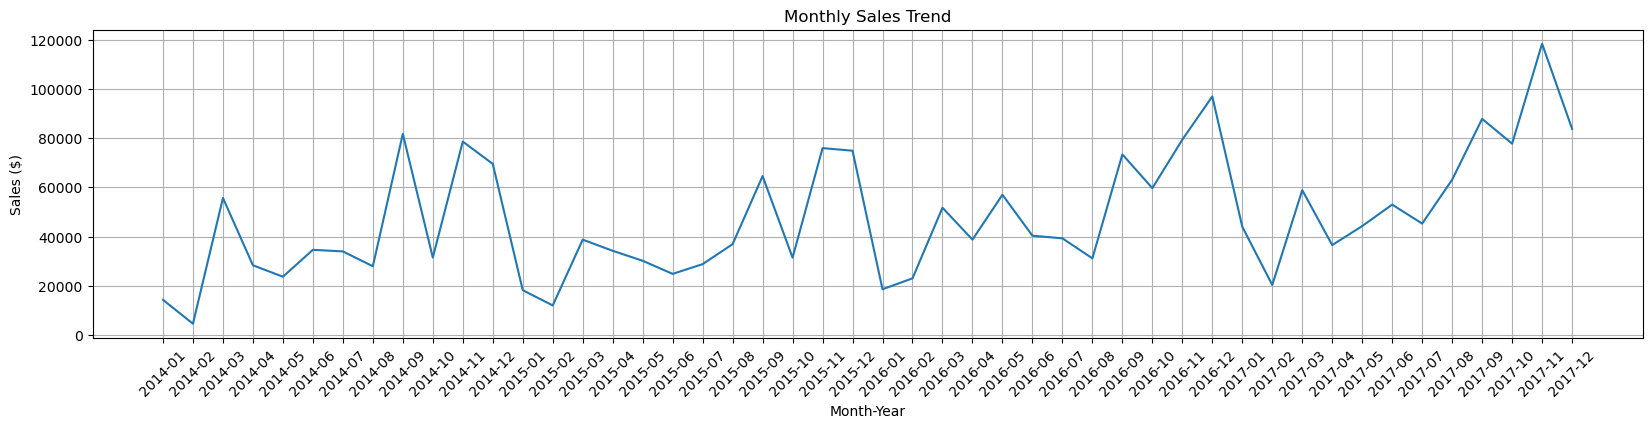

In [42]:
import matplotlib.pyplot as plt

# Convert to datetime
df['order_date'] = pd.to_datetime(df['order_date'])
df['month_year'] = df['order_date'].dt.to_period('M')

# Plot monthly sales
monthly_sales = df.groupby('month_year')['sales'].sum()
plt.figure(figsize=(20, 4))
plt.plot(monthly_sales.index.astype(str), monthly_sales.values)
plt.title("Monthly Sales Trend")
plt.xlabel("Month-Year")
plt.ylabel("Sales ($)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Profitability by Category


In [1]:
category_profit = df.groupby('category')['profit'].sum().sort_values()

plt.figure(figsize=(4, 3))
category_profit.plot(kind='barh', color='blue')
plt.title("Profit by Product Category")
plt.xlabel("Total Profit ($)")
plt.ylabel("Category")
plt.grid(axis='x')
plt.savefig('Profitability_By_Category.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'df' is not defined

In [50]:
pip install pandas pymysql

Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd
import pymysql

# Database connection
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='Mathruka@1',
    database='superstore_sales'
)

# List of tables to export
tables = ['customers', 'products', 'orders', 'order_details']

for table in tables:
    # Read table into DataFrame
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query, connection)
    
    # Export to CSV
    df.to_csv(f"{table}.csv", index=False)
    print(f"Exported {table} to {table}.csv")

connection.close()

C:\Users\mathr\AppData\Local\Temp\ipykernel_16668\4048907178.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Exported customers to customers.csv
Exported products to products.csv
Exported orders to orders.csv
Exported order_details to order_details.csv
